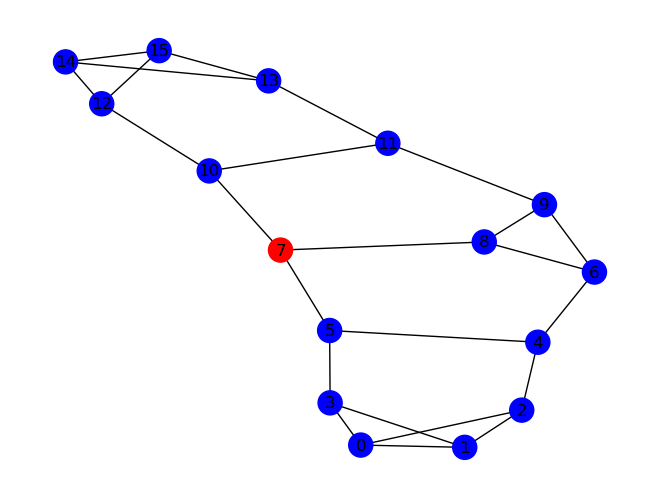

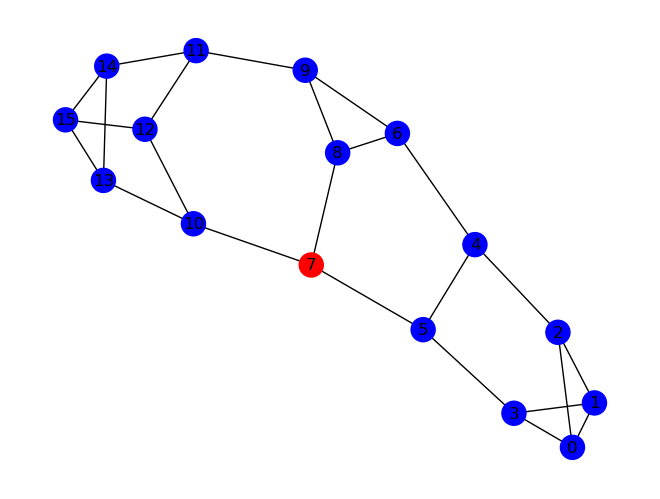

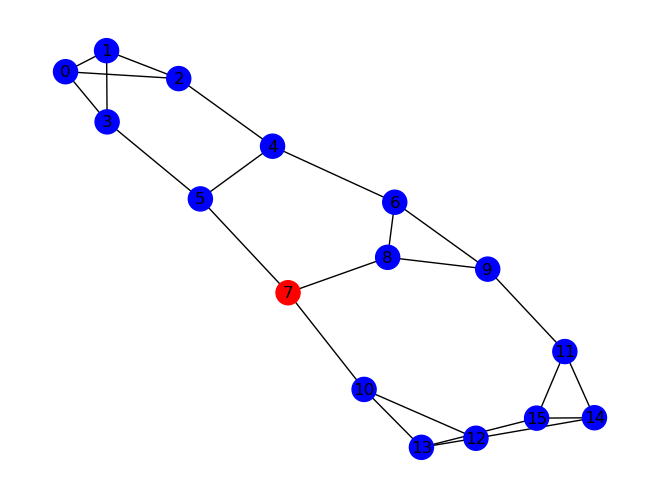

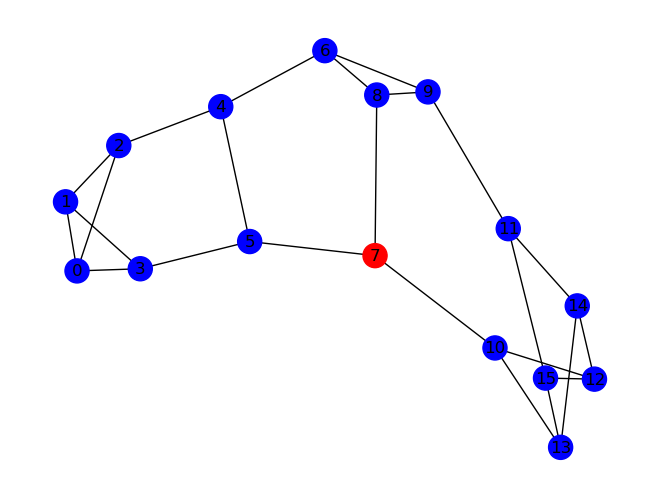

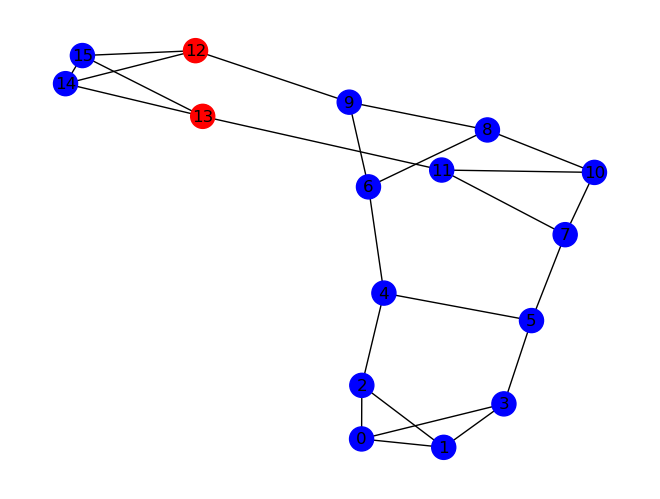

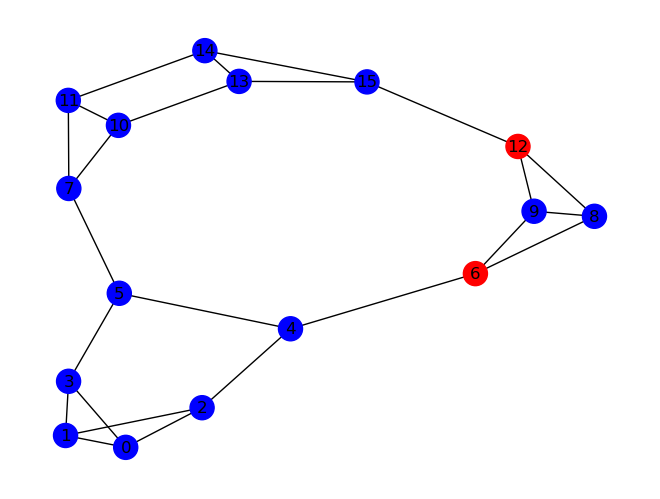

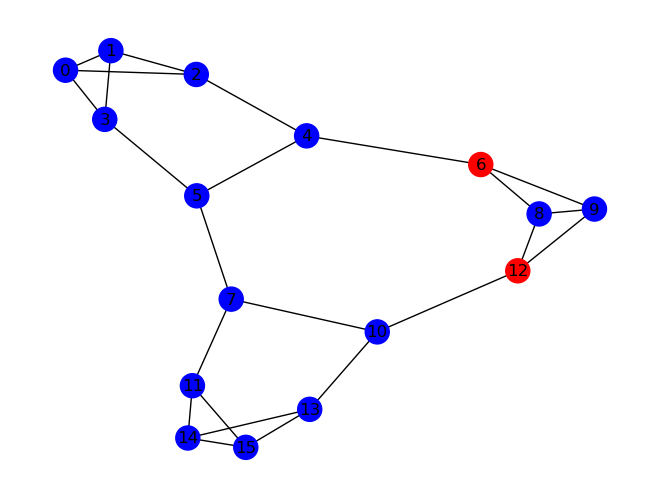

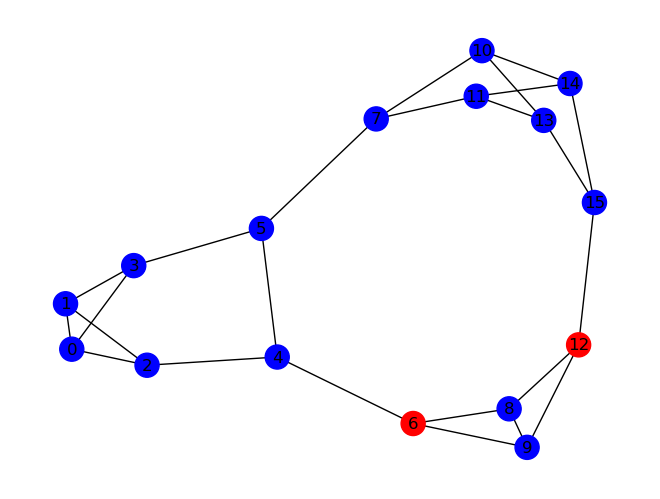

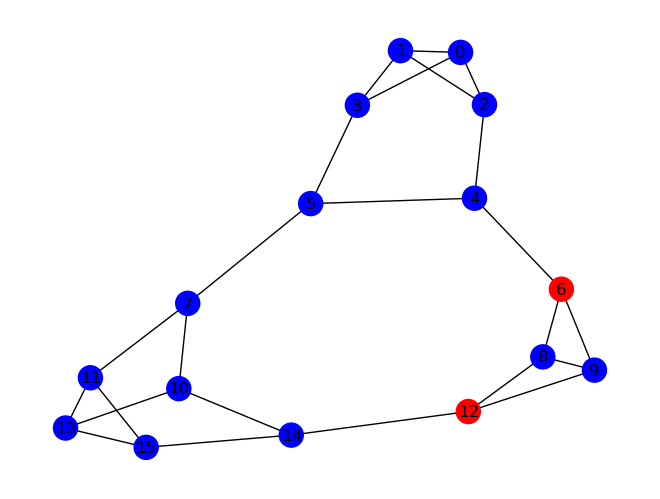

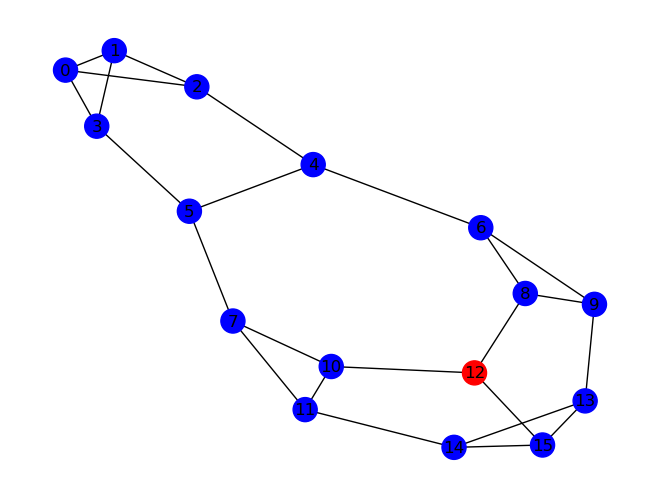

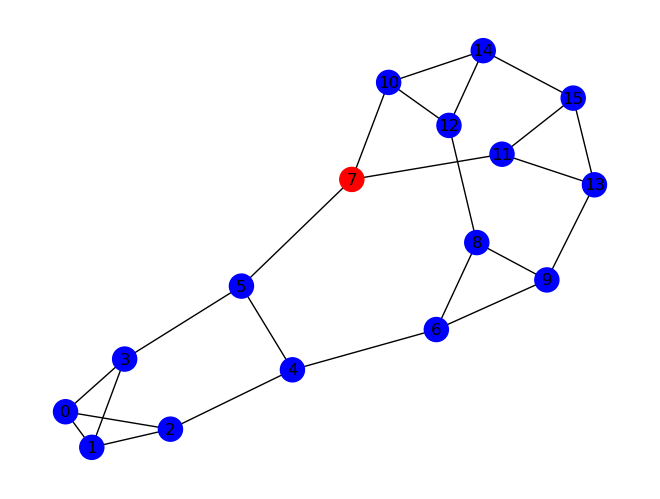

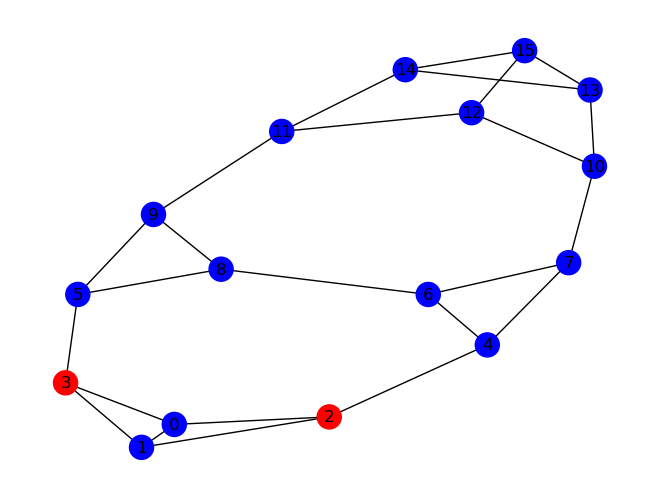

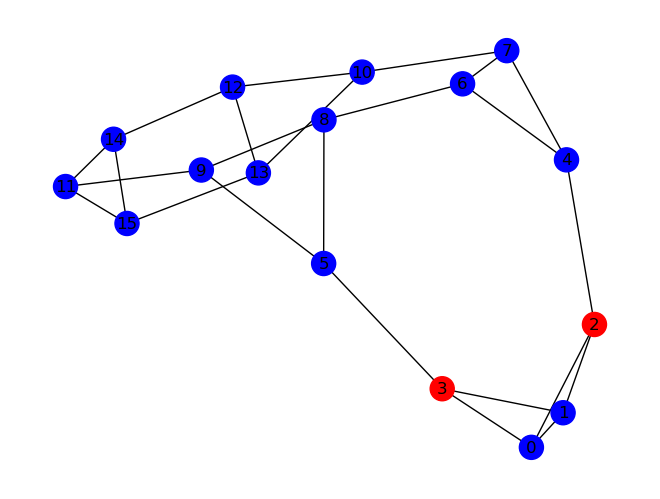

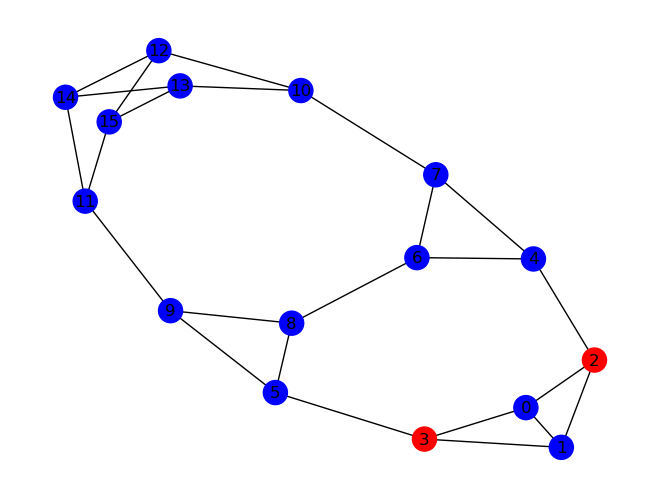

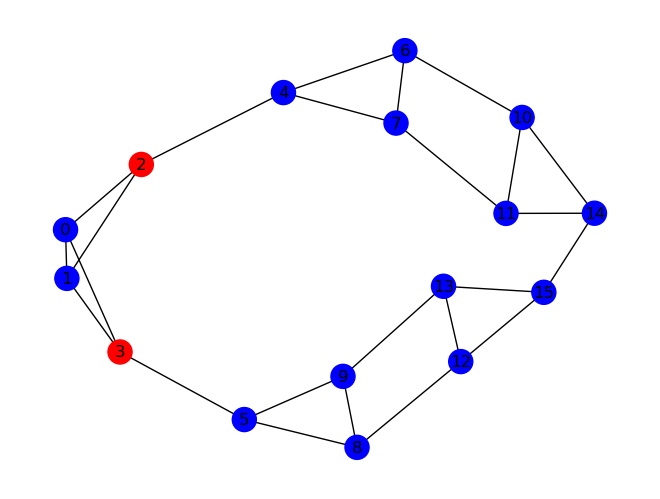

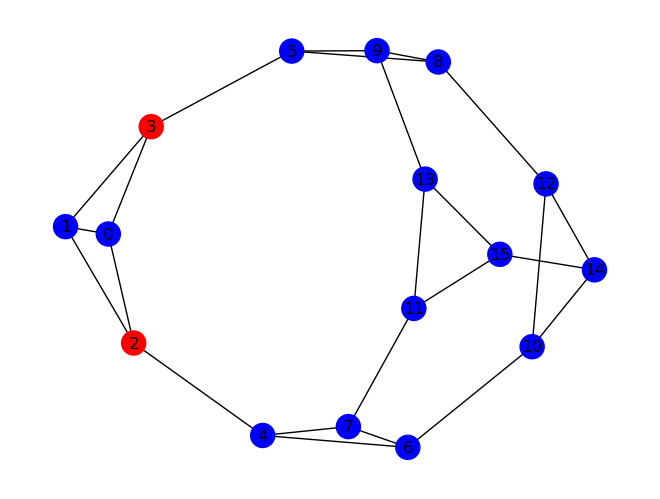

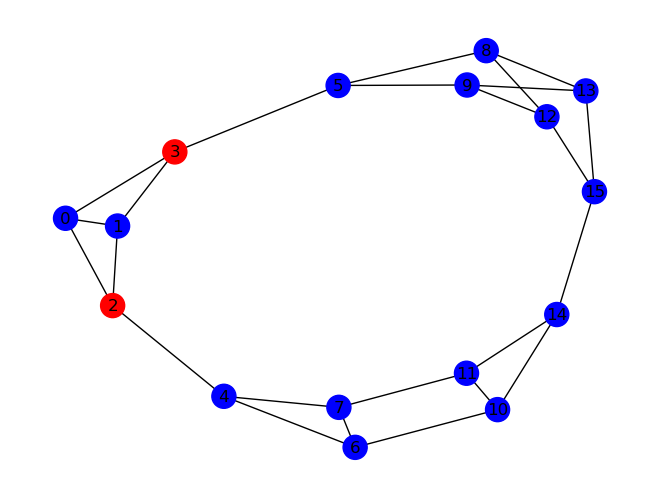

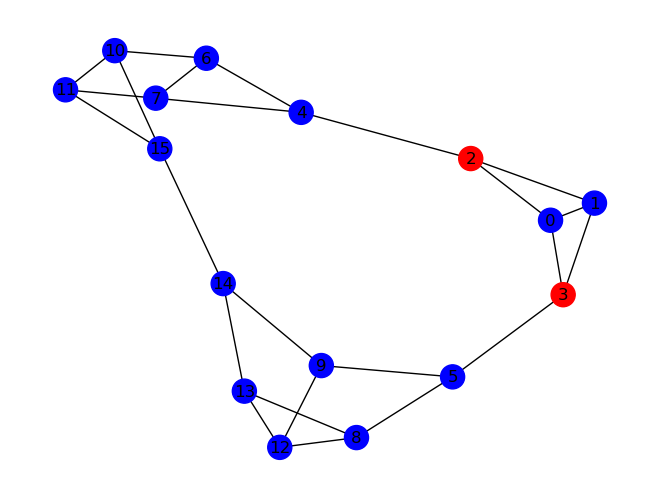

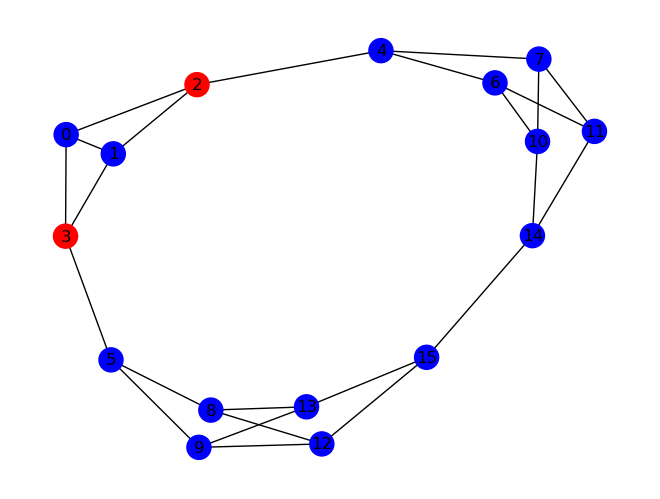

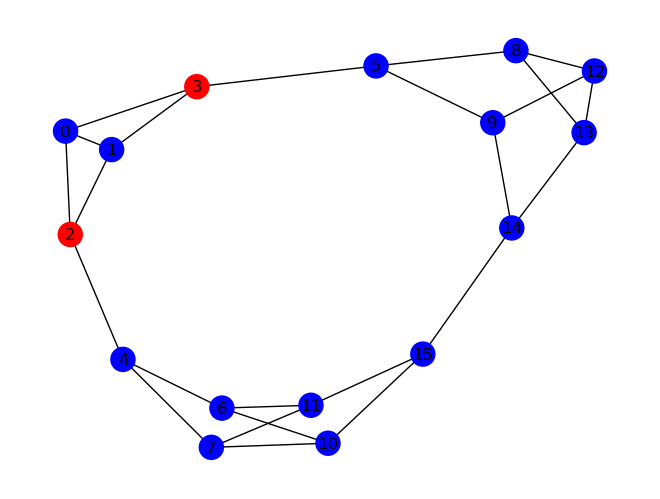

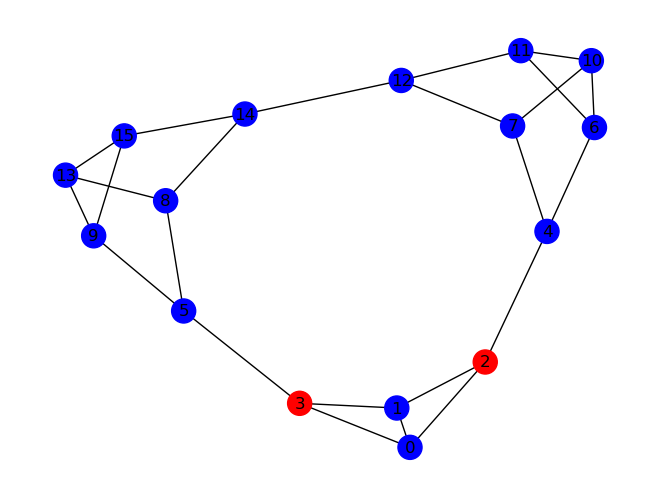

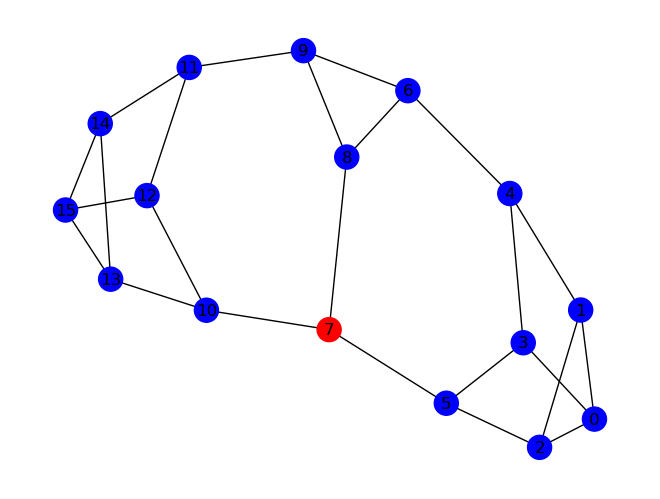

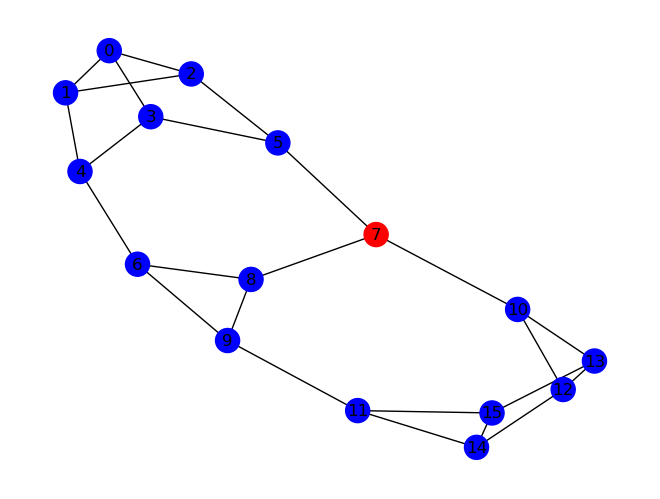

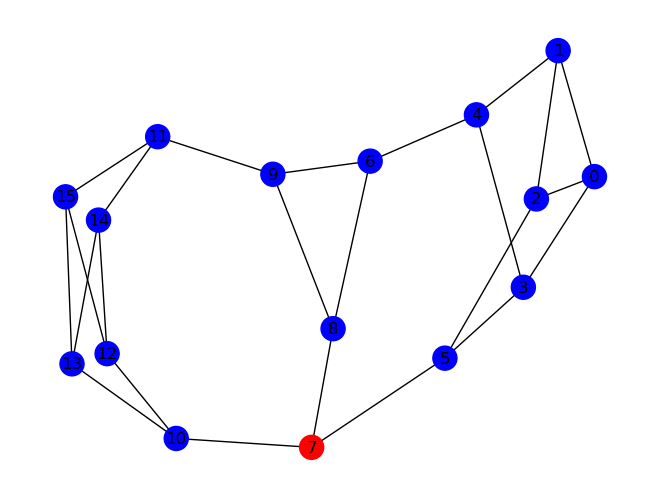

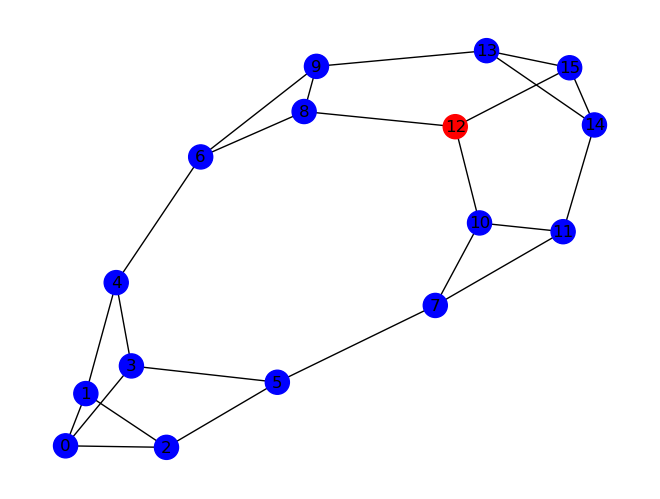

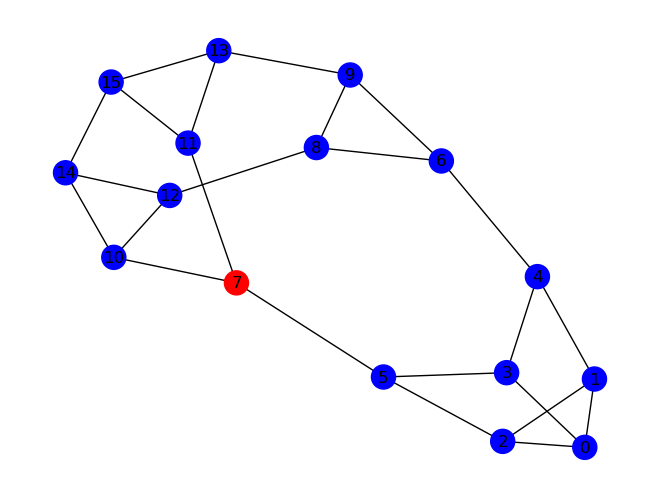

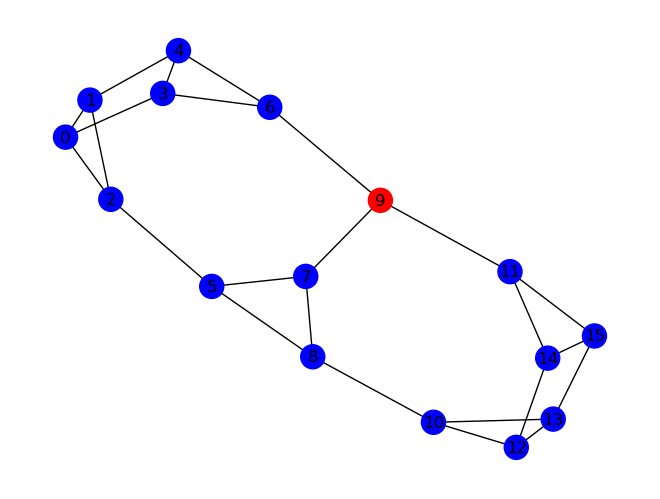

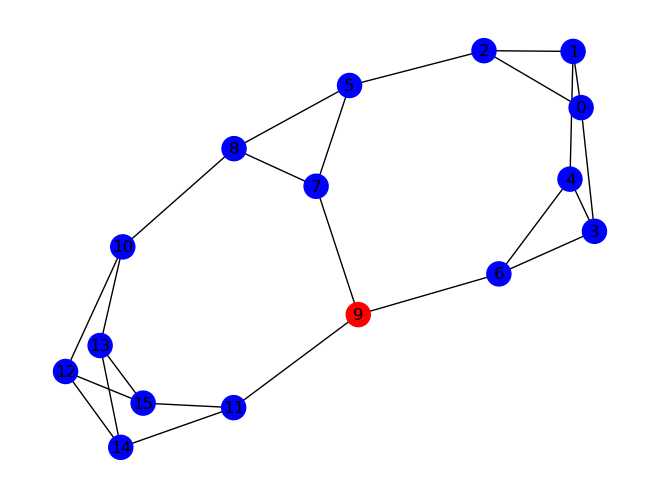

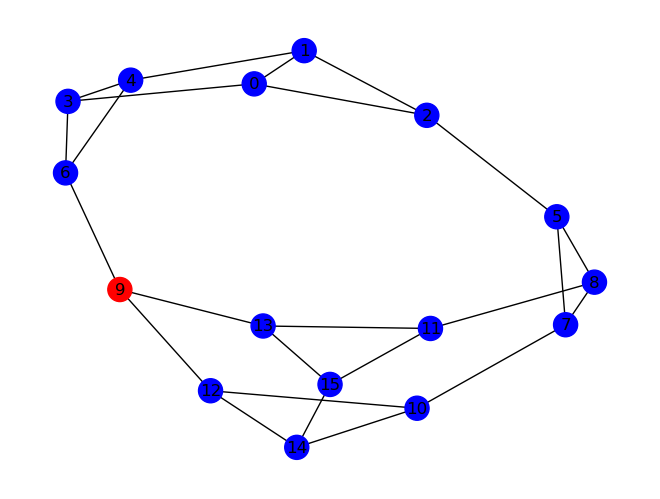

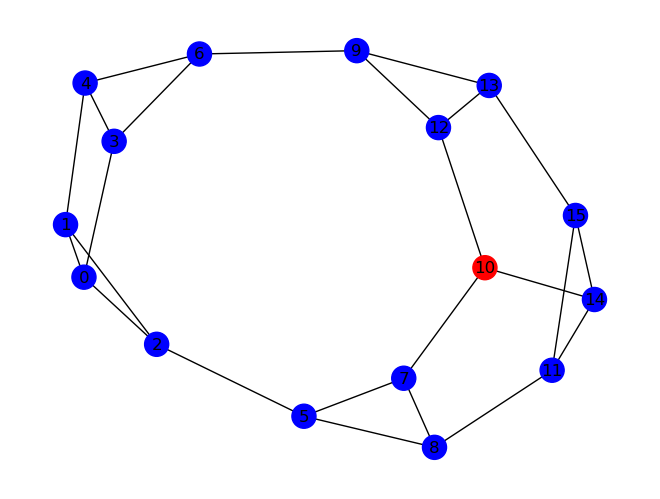

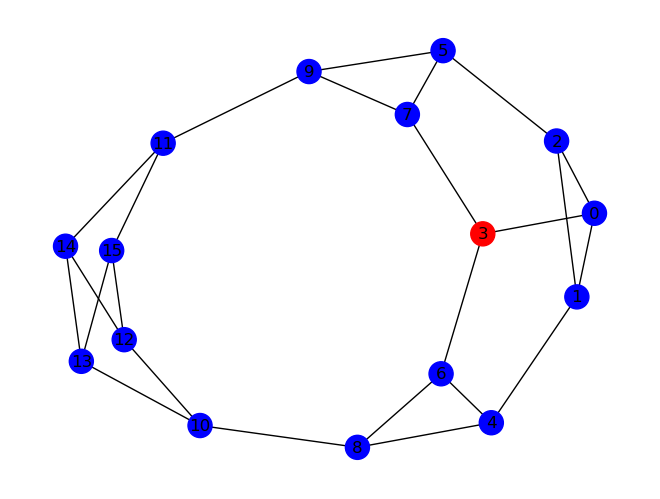

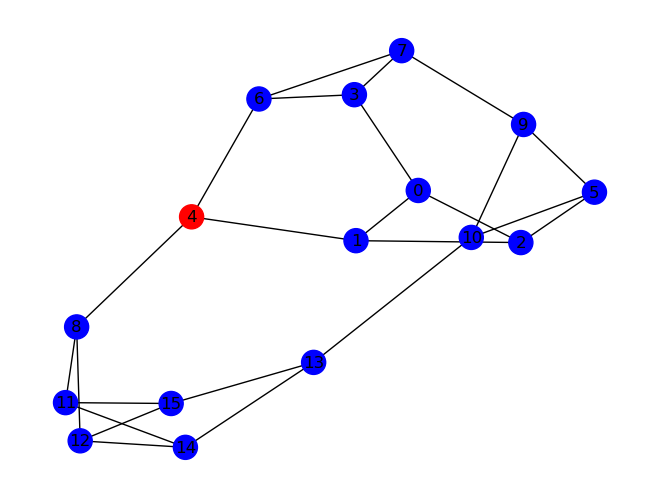

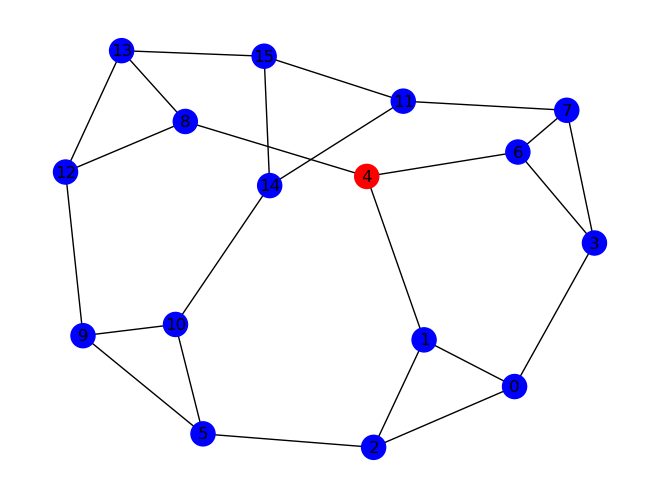

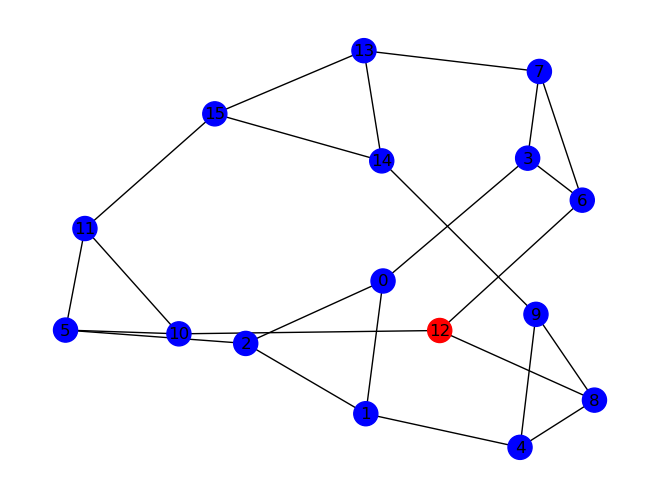

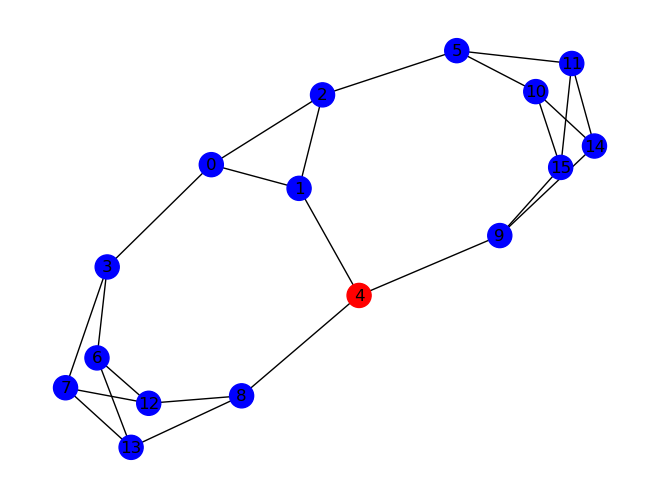

Number of graphs with MNSIS-essential vertices 0


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import os

essential_graphs = 0

def is_nsis(G, I):
    """
    Check if a subset of vertices I in graph G is a Non-Separating Independent Set (NSIS).
    
    Parameters:
        G : networkx.Graph
            The input graph.
        I : set or list
            A subset of vertices of G.
    
    Returns:
        bool
            True if I is a NSIS, False otherwise.
    """
    # Ensure I is a set
    I = set(I)
    
    # 1. Check if I is independent
    for u in I:
        for v in G.neighbors(u):
            if v in I:
                return False  # Adjacent vertices in I, not independent
    
    # 2. Check if G - I is connected
    G_minus_I = G.copy()
    G_minus_I.remove_nodes_from(I)
    
    return nx.is_connected(G_minus_I)

def find_maximum_nsis_bitmasks(G):
    """
    Enumerates all subsets and returns all MFVSs in bitmask form.
    """
    n = len(G.nodes())
    nodes = list(G.nodes())
    best_size = None
    max_nsis_masks = []

    for r in range(n, 0, -1):
        for combo in itertools.combinations(nodes, r):
            if is_nsis(G, combo):
                if best_size is None:
                    best_size = r
                if r == best_size:
                    # Convert to bitmask
                    mask = 0
                    for v in combo:
                        mask |= (1 << nodes.index(v))
                    max_nsis_masks.append(mask)
        if best_size is not None:
            break

    return max_nsis_masks, nodes

def draw_graph_with_highlight(G, nodes, union_mask, intersection_mask):
    """
    Draws the graph: nodes missing in the union (never in any FVS) are red, others blue.
    """
    colors = []
    has_essential = 0
    for i, v in enumerate(nodes):
        if intersection_mask & (1 << i):
            has_essential = 1
            colors.append("green") # appears in every MNSIS
        elif union_mask & (1 << i):
            colors.append("blue")  # appears in some MNSIS
        else:
            colors.append("red")   # never appears in any MNSIS
    global essential_graphs
    essential_graphs += has_essential
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=colors)
    plt.show()

def process_g6_files(file_list):
    for filename in file_list:
        with open(filename, "rb") as f:
            graphs = nx.read_graph6(f)

        for G in graphs:
            if nx.has_bridges(G):
                continue
            max_nsis_masks, nodes = find_maximum_nsis_bitmasks(G)

            if not max_nsis_masks:
                continue

            full_mask = (1 << len(nodes)) - 1
            # OR and AND all masks together
            union_mask = 0
            intersection_mask = full_mask
            for mask in max_nsis_masks:
                union_mask |= mask
                intersection_mask &= mask

            if union_mask != full_mask or intersection_mask:
                draw_graph_with_highlight(G, nodes, union_mask, intersection_mask)

# Example usage:
file_list = ["datasets/cub16.g6"]  # modify with your actual g6 files
process_g6_files(file_list)
print(f"Number of graphs with MNSIS-essential vertices {essential_graphs}")
